In [442]:
import pandas as pd
import numpy as np

In [443]:
DATASET_PATH = 'orders_all.csv'
PREPARED_DATASET_PATH = 'orders_all_prepared.csv'

Загружаем данные и смотрим основные характеристики.

In [444]:
df = pd.read_csv(DATASET_PATH, sep=";")
df.head()

,id_order,id_user,price,o_date
0,129,1,1337,26.04.2013
1,130,155,182,26.04.2013
2,131,1,602,26.04.2013
3,132,1,863,26.04.2013
4,133,1,2261,29.04.2013


In [445]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4365731 entries, 0 to 4365730
Data columns (total 4 columns):
id_order    int64
id_user     int64
price       int64
o_date      object
dtypes: int64(3), object(1)
memory usage: 133.2+ MB


In [446]:
df.describe()

,id_order,id_user,price
count,4.365731e+06,4.365731e+06,4.365731e+06
mean,5.147334e+06,3.325856e+06,1.603399e+09
std,3.509189e+06,3.011275e+06,3.350191e+12
min,1.290000e+02,0.000000e+00,-2.086000e+03
25%,1.812644e+06,5.880940e+05,7.340000e+02
50%,5.040464e+06,2.333255e+06,1.386000e+03
75%,8.403741e+06,5.422811e+06,2.496000e+03
max,1.697058e+07,9.900289e+06,7.000000e+15


In [447]:
df['id_order'].nunique()

4365731

Пропусков в колонках `id_order` и `id_user` нет. Все записи в колонке `id_order` уникальные.

In [448]:
initial_count = df.id_order.count()
initial_count

4365731

In [449]:
df.o_date.min()

'00.00.0000'

Нашли явно не валидные данные.

In [450]:
df.loc[df['o_date'] == '00.00.0000'].count()

id_order    55492
id_user     55492
price       55492
o_date      55492
dtype: int64

In [451]:
df.loc[df['o_date'] == '00.00.0000'].head()

,id_order,id_user,price,o_date
2136569,4900219,3764611,0,00.00.0000
2139866,4909909,3764611,0,00.00.0000
2139909,4910065,3764611,0,00.00.0000
2141378,4914559,3764611,0,00.00.0000
2141974,4916425,3764611,0,00.00.0000


In [452]:
df.loc[(df['o_date'] == '00.00.0000') & (df['price'] == 0)].count()

id_order    55492
id_user     55492
price       55492
o_date      55492
dtype: int64

Видим что в записях с невалидной датой цена везде равна нулю. Так что эти данные можно отбросить.

In [453]:
df.drop(df[(df['o_date'] == '00.00.0000')].index, inplace=True)

In [463]:
df.o_date.min()

'01.01.2014'

In [464]:
df.o_date.max()

'31.12.2017'

Поменяем тип данных для колонки `o_date`.

In [465]:
df['o_date'] = pd.to_datetime(df['o_date'])

In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4310239 entries, 0 to 4363046
Data columns (total 4 columns):
id_order    int64
id_user     int64
price       int64
o_date      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 164.4 MB


In [467]:
df.o_date.min()

Timestamp('2013-01-08 00:00:00')

In [468]:
df.o_date.max()

Timestamp('2018-12-27 00:00:00')

Теперь избавимся от невалидных данных в колонке `price`.

In [469]:
df.describe()

,id_order,id_user,price
count,4.310239e+06,4.310239e+06,4.310239e+06
mean,5.113639e+06,3.319858e+06,1.624042e+09
std,3.511263e+06,3.030090e+06,3.371688e+12
min,1.290000e+02,0.000000e+00,-2.086000e+03
25%,1.780412e+06,5.694485e+05,7.540000e+02
50%,4.959950e+06,2.263972e+06,1.400000e+03
75%,8.376397e+06,5.468550e+06,2.518000e+03
max,1.098539e+07,9.900289e+06,7.000000e+15


Для отрицательных значений поменяем знак.

In [470]:
df[df['price'] <= 0].count()

id_order    54
id_user     54
price       54
o_date      54
dtype: int64

In [471]:
df.loc[df['price'] < 0, 'price'] = df.loc[df['price'] < 0, 'price'] * -1

В колонке с ценой есть как нулевые данные, так и явные выбросы. Применим интерквартильный размах чтобы избавиться от выбросов.

In [472]:
IQ=df.price.describe()['75%']-df.price.describe()['25%']
low_border=df.price.describe()['25%']-IQ*1.5
high_border=df.price.describe()['75%']+IQ*1.5

In [473]:
print(IQ,low_border,high_border)

1764.0 -1892.0 5164.0


In [474]:
df.loc[df['price'] > high_border, 'price'].count()

342583

Нижняя граница получилась отрицательной, так что избавиться от нулевых данных таким образом не получится. Сперва я приравнял выбросы значений колонки `price` сверху и снизу (заказ менее 50 рублей) к медианному значению. Но потом решил что заказы в 0 рублей вполне могут быть. Например, если клиенту дали 100% скидку за ошибку магазина или не качественный сервис. Так же решил выкинуть данные с выбросами сверху. В конце проверим, какой процент данных мы потеряем.

In [475]:
df.drop(df[(df['price'] > high_border)].index, inplace=True)

Посмотрим, что у нас получилось.

In [476]:
df.describe()

,id_order,id_user,price
count,3.967656e+06,3.967656e+06,3.967656e+06
mean,5.105578e+06,3.306019e+06,1.562793e+03
std,3.517659e+06,3.033508e+06,1.125650e+03
min,1.290000e+02,0.000000e+00,0.000000e+00
25%,1.766375e+06,5.593480e+05,7.100000e+02
50%,4.928302e+06,2.237073e+06,1.272000e+03
75%,8.381790e+06,5.454628e+06,2.147000e+03
max,1.098539e+07,9.900289e+06,5.164000e+03


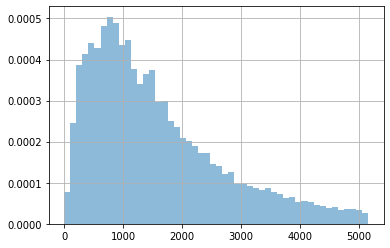

In [483]:
df['price'].hist(alpha = 0.5, bins=50, density=True)

In [478]:
result_count = df.id_order.count()
result_count

3967656

In [479]:
lost_percentage = (initial_count - result_count) * 100 / initial_count
lost_percentage

9.118175169290092

Потери в 9% данных вполне приемлемы. Сохраним результат обработки данных в файл.

In [480]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')